# Portfolio Optimizer 
#### Adam Suhajda 

### Abstract 
Elastic Net and LSTM Artificial Neural Net models were fitted for each portfolio constituent to predict their T1 returns. For Elastic Net, 5-fold validation was used, 2-fold validation if sample size was less than 4 records. LSTM Neural Net used 20% of the data for validation, rectified linear units for activation, ADAM for weight optimization, a max of 20 epochs or 4 as early stopping parameter. Both models were evaluated based on MAPE. Elastic Net performed better with a mean mape of 255.6 vs 396.3 of LSTM. Therefore considering the T1 forecasts from Elastic Net, assets with negative expected returns were disposed from portfolio. Random weights were then assigned to each asset 5.000 times and Information Ratio(IR) was calculated for each experiment. Portfolio weights were rebased daily to mitigate fluctuation of constituents over time. Portfolio with best IR of 53.15 was identified. Using kmeans, simulation results were also categorized into 3 categories based on their annualized return(AR): high, medium and low return categories. Best portfolios were identified for each category, potentially help suggesting the best selection for different risk appetites (high-return category IR:53.13, AR:0.109534; medium-return: IR:53.15, AR:0.109112; low-return: IR:50.810544, AR:0.103923). 252 trading days were assumed per year for annualization. 

### Caveats and research assumptions
- Portfolio weights sum up to 1 daily to mitigate changes of constituents over time. This assumes full capital investment every day. 
- Empirical results showed better model fit when forward and backfilling features compared to only filling NANs with 0s, hence assumption was made it is logically sound. 
- Based on brief provided, it was assumed T0 returns can't be used as predictor.
- In case of some IDs, predictions were stale or gravitated closely to the average of the T1 return, suggesting poor explanation power of features over "y". In a live environment I would entertain the idea of expanding the feature set (f.e. with macroeconomic news data). 
- It was observed LSTM Neural Network could improve MAPE significantly via more training epochs and/or higher early stopping parameter. Limited computation capacity didn't allow this optimization for the experiment.
- Early stopping doesn't guarantee best model selection as it can stop training not at the closest fit. In a live environment and to improve mape, I would recommend saving the models and selecting the one with best performance.

# Chapter 1 - Set environment
Import libraries and set the working environment  

In [2]:
'''
Import libraries
'''
# import libraries 
import pandas as pd
import os
import sklearn
import numpy as np
# adding progress bar to loops
from tqdm.notebook import tqdm_notebook
import time
# elastic net modeling
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_percentage_error
# LSTM Neural Network 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
# kmeans analysis
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

"""
Set working env: warning handling, work dir and random state
"""
# prevent jupyter cell from printing generic warning messages as we train so many RIC IDs, printing warnings will slow us down 
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


# set random state
np.random.seed(23)

# Chapter 2 - Load data
Below imports the dataset and performs basic cleaning activities:
- remove empty columns
- remove duplicates 
- sort the dataframe by date
- load .csv as pandas dataframe

In [3]:
"""
define data_load function and load data
"""
def load_data(dataset, date_column):
    # load csv
    df = pd.read_csv(dataset)
    # remove NAN columns 
    df = df.dropna(axis='columns', how='all')
    # remove duplicates 
    df = df.drop_duplicates()
    # set date column as datetime 
    df[date_column]= pd.to_datetime(df[date_column])
    # sort by date
    df = df.sort_values(by=date_column)
    # function returns the dataframe df 
    return(df)

# load data using our load data function 
df = load_data('SampleDataSet.csv', 'DATE')


# Chapter 3 - Forecast T1 returns 


I forecast the T1 return with 2 models I briefly elaborate and select the better performing solution for portfolio construction. 

## 3.1. Elastic Net
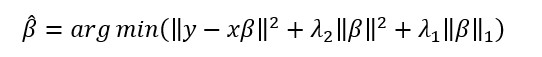

The model is a linear regression that also optimizes 2 lambda values. The first one: λ_2 ‖β‖^2, which contains the squared values is known from the Ridge methodology. The other one: λ_1 ‖β‖_1 is the regulation of the Lasso methodology in terms of regression coefficient penalization. 
Elastic Nets help to get the best from both Lasso & Ridge regressions, hence handles outliers and intercorrelation of variables well. While training: 
- I use the 5-fold cross validation methodology to validate model fit 
- As some IDs don't have enough history, I perform 2-fold cross validation for IDs with less than 4 records
- Evaluation is based on MAPE

## 3.2. LSTM Artificial Neural Network
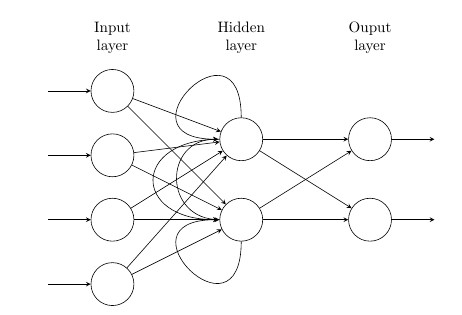

Long-term short-term Neural Net is a recurrent neural network which contains in-neuron memory cells that can maintain information in memory about previous states of the network, hence often used for time series modeling. 
It has the capability to re-set the information in a cell based on the previous state(time-step) in case it benefits fitting, while it's also easy for information to flow through the network without being changed.

For model train I apply the below parameters: 
- Train/test split of 80%/20%
- Rectified Linear Unit (ReLU) activation functions in neurons
- Maximum 20 epochs allowed per ID to manage computational capacity
- Stop training after no improvement in MAPE for 4 epochs 
- ADAM was used for optimization  
- Loss function evaluated on MAPE
- The LSTM Neural Network is assessed based on the validation dataset's fit.

In [3]:
# Create empty dataframe to append Forecast results 
df_forecast = df[0:0]

"""
Loop through each ID, train a model and save forecast stats
"""
for i in tqdm_notebook(range(len(set(df.RP_ENTITY_ID)))):
    """
    Iterate trhough each ID 
    """
    # filter experiment dataframe for single ID 
    df_experiment = df.loc[df['RP_ENTITY_ID'] == df.RP_ENTITY_ID[i]]
    # Remove rows where y is NAN 
    df_experiment = df_experiment[df_experiment['T1_RETURN'].notna()]
    # feature values are scattered across rows. Average seems to be an efficient way to aggregate per ID
    df_experiment = df_experiment.groupby(['DATE', 'RP_ENTITY_ID'], as_index=False).mean()

    '''
    Create X and y dataset to split predictors & dependent variable 
    '''
    # Create feature dataframe 
    df_x = df_experiment[df_experiment.columns[2:30]]
    # forward and backfill time series as it resulted better R2 values than just filling w with 0s 
    df_x = df_x.fillna(method='ffill')
    df_x = df_x.fillna(method='bfill')
    df_x = df_x.fillna(0)
    # Convert data frame to numeric array for model input 
    X = df_x.values

    # Create y dataframe
    df_y = df_experiment [['T1_RETURN']]
    # Convert dataframe to numeric array for model input 
    y = df_y.values.ravel()
    
    
    """Elastic Net Model"""
    # if sample size is larger then 4, do 5-fold cross validation, otherwise 2-fold
    if len(df_experiment)>4: 
        cross_val = 5
    else: 
        cross_val =2
    # define Elastic net with X-fold cross validation 
    regr = ElasticNetCV(cv=cross_val, random_state=10 )
    # fit elastic net model
    regr.fit(X, y)
    # predict with elastic net model
    en_fc = regr.predict(X)
    # calculate MAPE
    en_mape = mean_absolute_percentage_error( y, en_fc)
    
    # saving elastic net forecast for T1 
    df_experiment['ELASTIC_NET_T1_FC'] = en_fc
    # saving elastic net mape, * by 100 as SkLearn's MAPE metrics is not in percentage while in Keras/Tensorflow it is 
    df_experiment['ELASTIC_NET_MAPE'] = en_mape*100
    
    '''
    LSTM Neural Network Model 
    '''
    # tell model to stop learning if performance didn't imporve since last N epochs indicated by early stopping
    early_stopping = EarlyStopping(patience = 4)
    # creates LSTM netrwork with input neuron nb set to nb of features, decreases gradually after until output layer
    model = Sequential()
    model.add(LSTM(units=len(df_x.columns), activation='relu', return_sequences=True,input_shape=(X.shape[1], 1)))
    model.add(LSTM(units=round(len(df_x.columns)/2), activation='relu', return_sequences=True))
    model.add(LSTM(units=round(len(df_x.columns)/4),activation='relu', return_sequences=False))
    model.add(Dense(units=1))
    # optimizer adam, loss metrics mape to ensure comparability with Eastic Net 
    model.compile(optimizer='adam', loss='mape', metrics=['mape'])
    # fit defined LSTM neural net. Letting it try forecasting 20 times to learn 
    model = model.fit(X,y,epochs=20,
            validation_split=0.2,
            verbose = 0,
            callbacks=[early_stopping])
    # create forecast with LSTM neural network  
    lstm_fc = model.model.predict(X)
    # store validation MAPE values 
    lstm_mape = model.history['val_loss'][-1:]
    # save LSTM  forecast for T1 in dataframe
    df_experiment['LSTM_T1_FC'] = lstm_fc
    # converts MAPE to a float data type 
    lstm_mape = float(np.asarray(lstm_mape, dtype=np.float64))
    # saves into df_experiment 
    df_experiment['LSTM_MAPE'] = lstm_mape
    
    "Append experiment dataframes to forecast dataframe"
    df_forecast = df_forecast.append(df_experiment)


In [4]:
# print header of dataframe with forecasted results 
df_forecast.head()

,DATE,RP_ENTITY_ID,GLOBAL_ALL,GLOBAL_HEAD,GLOBAL_BODY,GLOBAL_ALL_SG90,GLOBAL_HEAD_SG90,GLOBAL_BODY_SG90,GLOBAL_ALL_SG365,GLOBAL_HEAD_SG365,...,GROUP_E_ALL_SG365,GROUP_E_HEAD_SG365,GROUP_E_BODY_SG365,GROUP_AM_BODY,T0_RETURN,T1_RETURN,ELASTIC_NET_T1_FC,ELASTIC_NET_MAPE,LSTM_T1_FC,LSTM_MAPE
0,2005-01-03,0157B1,0.61,NaN,0.61,0.61,NaN,0.61,0.61,NaN,...,0.61,NaN,0.61,0.61,0.018520,-0.037526,0.000598,238.736895,-0.000612,153.599304
1,2005-01-04,0157B1,-0.98,-0.98,-0.98,-0.98,-0.98,-0.98,-0.98,-0.98,...,NaN,NaN,NaN,-0.98,-0.037526,0.000516,0.000598,238.736895,-0.000612,153.599304
2,2005-01-05,0157B1,-0.98,NaN,-0.98,-0.98,NaN,-0.98,-0.98,NaN,...,NaN,NaN,NaN,-0.98,0.000516,-0.020898,0.000598,238.736895,-0.000612,153.599304
3,2005-01-10,0157B1,0.55,NaN,0.55,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.55,-0.015596,0.001851,0.000598,238.736895,-0.000612,153.599304
4,2005-01-14,0157B1,0.54,NaN,0.54,0.54,NaN,0.54,0.54,NaN,...,0.54,NaN,0.54,0.54,0.037980,-0.009115,0.000598,238.736895,-0.000612,153.599304


## 3.3. Model selection 
Model selection is performed based on Mean Absolute Percentage Error(MAPE). 
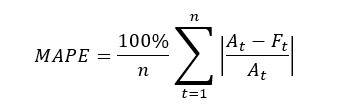
Where: 
- n	number of times the iteration happens
- A_t actual value
- F_t forecast value

It can be seen that MAPE shows the mean absolute value of the % error between the actual and model-calculated data points allowing for easy interpretation. 

In [5]:
print("ELASTIC NET MAPE:")
df_forecast.ELASTIC_NET_MAPE.mean()

ELASTIC NET MAPE:


255.633856019642

In [6]:
print("LSTM NEURAL NETWORK MAPE:")
df_forecast.LSTM_MAPE.mean()

LSTM NEURAL NETWORK MAPE:


396.31706937515247

As visible, both MAPEs are relatively high, in general I would revisit the feature set instead. One could explore more indicators such as macroeconomic news or sentiment indicators. 

For the purpose of the exercise, I'll proceed. As seen, the Elastic Net model has the smaller error on average, hence the portfolio will be optimized using it's T1 returns forecasted by that model.

# Chapter 4 - Portfolio optimization 

The portfolio is optimized in a Monte Carlo fashion: 
- the script assigns a random weight to each ID and calculates the Information Ratio (IR)
- this is reiterated 5.000 times, IR is calculated with every iteration
- each simulation and related details are stored in a dataframe with an assigned simulation ID.

In [7]:
"""
Set out-of-loop objects
"""

# construct empty DF to store simulation results
df_simulation = pd.DataFrame(columns=['EXPERIMENT_ID', 'RP_ENTITY_ID', 'WEIGHTS', 'ANNUALIZED_RETURN', 'EXPECTED_VOLATILTIY', 'INFORMATION_RATIO'])

# Get Date, ID and T1 forecast from better modelto be joined with weights while optimizing. 
df_portfolio_opt = df_forecast[['DATE', 'RP_ENTITY_ID', 'ELASTIC_NET_T1_FC' ]]

# dispose  with negative annual returns based on T1 forecast to make it more effective building a good portfolio
df_positive_ret = df_portfolio_opt.groupby(['RP_ENTITY_ID'], as_index=False).mean()
df_positive_ret = df_positive_ret[(df_positive_ret.ELASTIC_NET_T1_FC >= 0)]
df_portfolio_opt = df_portfolio_opt[df_portfolio_opt['RP_ENTITY_ID'].isin(df_positive_ret.RP_ENTITY_ID)]

# drop duplicate rows in case  
df_portfolio_opt = df_portfolio_opt.drop_duplicates()
# reset index for dataframe
df_portfolio_opt = df_portfolio_opt.reset_index(drop=True)

# number of random simulations 
simulation_length = 5000

# create unique list of IDs per day 
id_len = len(set(df_portfolio_opt.RP_ENTITY_ID))

"""
Loop to build porfolios starts  
"""
# generate random weights & calculate portfolio metrics as many times as defined by simulation_length
for i in tqdm_notebook(range(simulation_length)):
    
    # create ID for experiment 
    experiment_id = 100+i
    
    """
    Generate random portfolio weights
    """
    # create random vector of weights between 0 and 100
    random_portfolio_weights = np.random.uniform(low=0, high=100, size=(id_len,))
    # make sure weights sum to 100% for number of IDs (we'll later rebase daily as well)
    random_portfolio_weights = random_portfolio_weights/sum(random_portfolio_weights)
    # cast data typeas float  
    random_portfolio_weights = random_portfolio_weights.astype(float)
    
    # create a list of unique IDs 
    ids = np.array(list(set(df_portfolio_opt.RP_ENTITY_ID)))
    # create a dataframe with IDs & random weights 
    df_weights = pd.DataFrame({'PORTFOLIO_WEIGHT':random_portfolio_weights, 'RP_ENTITY_ID':ids})
    # merge dataframes with weights, returns & portfolio IDs 
    df_experiment = df_portfolio_opt.merge(df_weights, on='RP_ENTITY_ID', how='left')
    
    # Rebase weight on daily basis to mitigate constituent changes 
    df_rebase = df_experiment.groupby(['DATE'], as_index=False).sum()
    df_rebase['REBASER']= 1/df_rebase.PORTFOLIO_WEIGHT
    df_experiment = df_experiment.merge(df_rebase[['DATE', 'REBASER']], on='DATE', how='left')
    df_experiment['PORTFOLIO_WEIGHT']= df_experiment.PORTFOLIO_WEIGHT * df_experiment.REBASER
    
    """
    Compute Average Return per day on Portfolio basis 
    """
    # create weighted return 
    df_experiment['WEIGHTED_RETURN'] = df_experiment.ELASTIC_NET_T1_FC * df_experiment.PORTFOLIO_WEIGHT
    # calculate daily return 
    df_daily_ret = df_experiment.groupby(['DATE'], as_index=False).sum()
    # rename column to daily return for aggregated values
    df_daily_ret.rename(columns = {'WEIGHTED_RETURN':'DAILY_WEIGHTED_RETURN'}, inplace = True)
    # aggregate return by day  
    df_experiment = df_experiment.merge(df_daily_ret[['DATE', 'DAILY_WEIGHTED_RETURN']], on='DATE', how='left')
    
    """
    Calculate key metrics: annual return, annual volatility and Information Ratio
    """
    #Annualized return
    annualized_return = np.log(np.sum((df_experiment.DAILY_WEIGHTED_RETURN.mean())*252)+1)
    # Annualized volatility
    annualized_volatility = np.sqrt(np.log(df_experiment.DAILY_WEIGHTED_RETURN+1).var())*np.sqrt(252)
    # Information Ratio 
    InformationRatio = annualized_return/annualized_volatility
    
    """
    append results to simulation database for each iteration
    """
    df_simulation = df_simulation.append({'EXPERIMENT_ID': experiment_id, 'RP_ENTITY_ID': np.array(df_experiment.RP_ENTITY_ID), 'WEIGHTS': random_portfolio_weights, 'ANNUALIZED_RETURN': np.array(annualized_return) , 'EXPECTED_VOLATILTIY': np.array(annualized_volatility) , 'INFORMATION_RATIO':np.array(InformationRatio) }, ignore_index=True)
    

# Chapter 5 - Portfolio evaluation  
## 5.1. - selecting best portfolio based on Information Ratio

Using the simulation database constructed in Chapter 4, the best portfolio is identified based on it's Information Ratio value.
Related information such as weight per ID is also stored for future usage. 

In [8]:
# identify portfolio with highest IR 
best_portfolio = df_simulation[df_simulation.INFORMATION_RATIO == df_simulation.INFORMATION_RATIO.max()]
best_portfolio

,EXPERIMENT_ID,RP_ENTITY_ID,WEIGHTS,ANNUALIZED_RETURN,EXPECTED_VOLATILTIY,INFORMATION_RATIO
3448,3548,"[0157B1, 0157B1, 0157B1, 0157B1, 0157B1, 0157B...","[0.002087018615588391, 0.0032022675894823106, ...",0.10911236873735496,0.002052690916905914,53.15577120681349


Below, the distribution of the portfolios is plotted and Experiment ID 3548 is highlighted in red circle to put results into perspective.

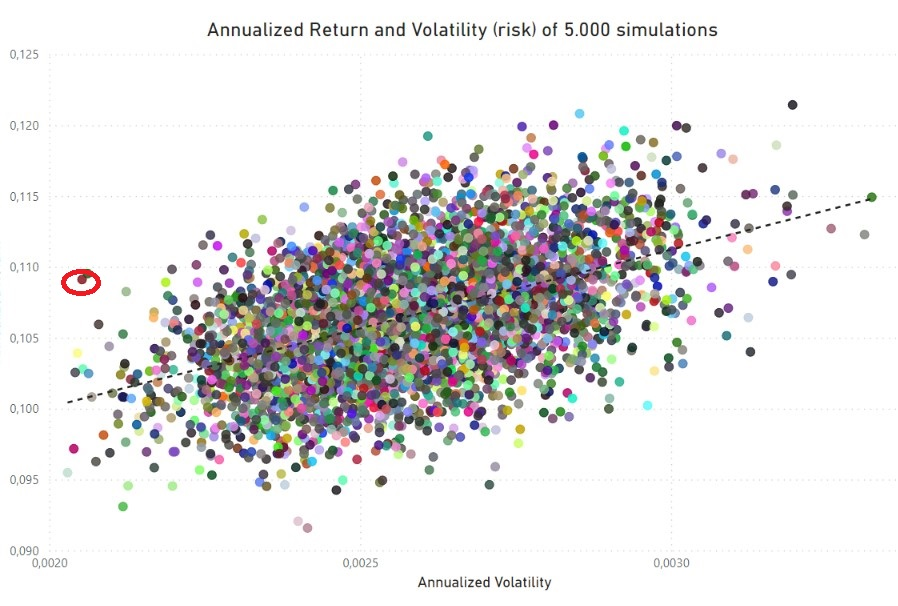

## 5.2. K Means experiment to categorize portfolios by annualized return 

The best portfolio based on IR was identified, but there are investors with different risk appetites. It might make sense for them to be provided alternatives considering higher return and higher volatility portfolios as well. For this purpose, portfolio annualized returns are used to assign experiments into 3 categories using kmeans clustering.

This leverages unsupervised learning, and simply assigns portfolios into 0,1 or 2 categories (3 clusters). I don't cover the math behind k means here as there's extensive literature available, simply put it creates groups in a manner intra-cluster variance is minimized. 

The 3 logical groups in this case, one could interpret are: 
- high-return class of portfolios (dark blue)
- medium return class of portfolios  (light blue) 
- low return low risk (orange)


In [11]:
# passes portfolio Information Ratio as X to kmeans algorithm 
X = df_simulation.ANNUALIZED_RETURN.values
X = X.reshape(-1, 1)

# craetes 3 clusters (low, medium and high risk tolerance)
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X)

# adds portfolio type to simulation dataframe 
df_simulation['PORTFOLIO_TYPE'] = kmeans.predict(X)

In [14]:
"""
Identify and print best portfolios per category 
"""
# Separate dataset per ID 
df_0_low_ret = df_simulation[df_simulation.PORTFOLIO_TYPE == 2]
df_2_mid_ret = df_simulation[df_simulation.PORTFOLIO_TYPE == 0]
df_1_high_ret = df_simulation[df_simulation.PORTFOLIO_TYPE == 1]
# print best low return 
best_portfolio_low_ret = df_0_low_ret[df_0_low_ret.INFORMATION_RATIO == df_0_low_ret.INFORMATION_RATIO.max()]
print("-----------------------LOW RETURN CATEGORY------------------------------:"), 
print("BEST INFORMATION RATIO IN CATEGORY:"), print(best_portfolio_low_ret.INFORMATION_RATIO)
print("EXPECTED ANNUALIZED RETURN:"), print(best_portfolio_low_ret.ANNUALIZED_RETURN)
print("EXPERIMENT ID:"), print(best_portfolio_low_ret.EXPERIMENT_ID)

# print best mid-return
best_portfolio_mid_ret = df_2_mid_ret[df_2_mid_ret.INFORMATION_RATIO == df_2_mid_ret.INFORMATION_RATIO.max()]
print("-----------------------MEDIUM RETURN CATEGORY------------------------------:"), 
print("BEST INFORMATION RATIO IN CATEGORY:"), print(best_portfolio_mid_ret.INFORMATION_RATIO)
print("EXPECTED ANNUALIZED RETURN:"), print(best_portfolio_mid_ret.ANNUALIZED_RETURN)
print("EXPERIMENT ID:"), print(best_portfolio_mid_ret.EXPERIMENT_ID)

# print best high-ret
best_portfolio_high_ret = df_1_high_ret[df_1_high_ret.INFORMATION_RATIO == df_1_high_ret.INFORMATION_RATIO.max()]
print("-----------------------HIGH RETURN BEST IR------------------------------:"), 
print("BEST INFORMATION RATIO IN CATEGORY:"), print(best_portfolio_high_ret.INFORMATION_RATIO)
print("EXPECTED ANNUALIZED RETURN:"), print(best_portfolio_high_ret.ANNUALIZED_RETURN)
print("EXPERIMENT ID:"), print(best_portfolio_high_ret.EXPERIMENT_ID)

-----------------------LOW RETURN CATEGORY------------------------------:
BEST INFORMATION RATIO IN CATEGORY:
833    50.810544
Name: INFORMATION_RATIO, dtype: float64
EXPECTED ANNUALIZED RETURN:
833    0.103923
Name: ANNUALIZED_RETURN, dtype: float64
EXPERIMENT ID:
833    933
Name: EXPERIMENT_ID, dtype: int64
-----------------------MEDIUM RETURN CATEGORY------------------------------:
BEST INFORMATION RATIO IN CATEGORY:
3448    53.155771
Name: INFORMATION_RATIO, dtype: float64
EXPECTED ANNUALIZED RETURN:
3448    0.109112
Name: ANNUALIZED_RETURN, dtype: float64
EXPERIMENT ID:
3448    3548
Name: EXPERIMENT_ID, dtype: int64
-----------------------HIGH RETURN BEST IR------------------------------:
BEST INFORMATION RATIO IN CATEGORY:
2049    53.131274
Name: INFORMATION_RATIO, dtype: float64
EXPECTED ANNUALIZED RETURN:
2049    0.109534
Name: ANNUALIZED_RETURN, dtype: float64
EXPERIMENT ID:
2049    2149
Name: EXPERIMENT_ID, dtype: int64


(None, None)

The following plot helps to visualize the best portfolios per category based on Information Ratio (high return - dark blue, mid return - light blue, low return - orange): 
- investors with higher risk appetite could go for Portfolio Exp.ID 2149, in dark blue circle
- investors looking for best IR could go for the best IR in light blue
- low risk tolerance investors could be offered to go for Exp.ID 933 in orange, sacrificing some return for less volatility 

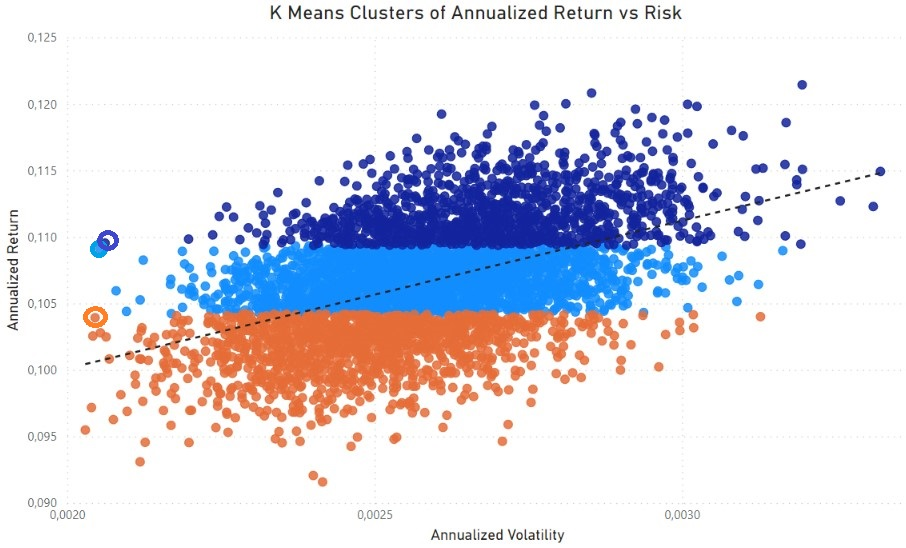